# **Set up**

In [1]:
!pip install summarytools
!pip install vncorenlp

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.2 MB/s eta 0:00:00
  Created wheel for summarytools: filename=summarytools-0.2.3-py3-none-any.whl size=8572 sha256=d84804de9302f849fa85349183f3b90f0003fc1fe16c78159ab16ea02a227545
  Stored in directory: /root/.cache/pip/wheels/d5/8a/5d/008e2127a7f9dd64d066f16e5ea268fa52823dc929c982d6f1
Successfully built summarytools
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 17.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for vncorenlp: filename=vncorenlp-1.0.3-py3-none-any.whl size=2645932 sha256=18c0a73153d064497ba1d03907a25d19944ed53936a3b0d50276870c6fd80a7a
  Stored in directory: /root/.cache/pip/wheels/5d/d9/b3/41f6c6b1ab758561fd4aab55dc0480b9d7a131c6aaa573a3fa
Successfully built vncorenlp


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from vncorenlp import VnCoreNLP
from sklearn.decomposition import PCA

from sklearn.multioutput import MultiOutputClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

from summarytools import dfSummary
from collections import Counter

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!mkdir -p vncorenlp/models/wordsegmenter
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/wordsegmenter.rdr
!mv VnCoreNLP-1.1.1.jar vncorenlp/
!mv vi-vocab vncorenlp/models/wordsegmenter/
!mv wordsegmenter.rdr vncorenlp/models/wordsegmenter/

--2024-01-07 08:38:38--  https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27412575 (26M) [application/octet-stream]
Saving to: ‘VnCoreNLP-1.1.1.jar’

VnCoreNLP-1.1.1.jar 100%[===================>]  26.14M  --.-KB/s    in 0.1s    

2024-01-07 08:38:39 (250 MB/s) - ‘VnCoreNLP-1.1.1.jar’ saved [27412575/27412575]

--2024-01-07 08:38:39--  https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting respon

# **Training Set Preparation**

In [5]:
aspect_cols = ['GENERAL', 'SCREEN', 'CAMERA', 'FEATURES', 'BATTERY', 'PERFORMANCE', 'STORAGE', 'DESIGN', 'PRICE', 'SER&ACC']

In [6]:
df_train = pd.read_csv("/content/drive/MyDrive/HocMayThongKe/Project/Preprocessed Dataset/df_train.csv")
df_train

,comment,GENERAL,SCREEN,CAMERA,FEATURES,BATTERY,PERFORMANCE,STORAGE,DESIGN,PRICE,SER&ACC,OTHERS
0,Mới mua máy này Tại thegioididong thốt nốt cảm...,1,0,1,1,1,0,0,0,1,1,0
1,Pin kém còn lại miễn chê mua 8/3/2019 tình trạ...,1,0,0,0,-1,0,0,0,0,0,1
2,Sao lúc gọi điện thoại màn hình bị chấm nhỏ nh...,0,0,0,-1,0,0,0,0,0,0,0
3,"Mọi người cập nhật phần mềm lại , nó sẽ bớt tố...",0,0,0,-1,0,0,0,0,0,0,0
4,"Mới mua Sài được 1 tháng thấy pin rất trâu, Sà...",0,0,0,0,1,1,0,0,0,-1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
7781,8g. Cái đi đánh là mạng giật giật ko chịu nổi....,0,0,0,-1,-1,-1,0,0,0,0,0
7782,Mua dk giảm 500k mà lỗi lòi ra hết treo màn hì...,0,0,0,-1,0,-1,0,0,1,0,0
7783,Máy Sài 3 tháng rồi rất OK.pin trâu khỏi nói S...,1,0,0,0,1,1,0,0,0,0,0
7784,"Rất tiếc hàng realme ko có ốp lưng ngoài , nên...",1,0,0,0,0,0,0,0,-1,-1,0


In [7]:
rdrsegmenter = VnCoreNLP("/content/vncorenlp/VnCoreNLP-1.1.1.jar", annotators="wseg", max_heap_size='-Xmx500m')

In [8]:
def tokenize(row):
    processed_row = ""
    tokenized_sents = rdrsegmenter.tokenize(row)
    for lst_token_in_sent in tokenized_sents:
        processed_row += " ".join(lst_token_in_sent)

    return processed_row

In [9]:
def dataframe_tokenize(df):
    processed_rows = []
    for row in df['comment']:
        processed_rows.append(tokenize(row))

    return processed_rows

In [10]:
tfidf_vectorizer = TfidfVectorizer()

X_train_tok = dataframe_tokenize(df_train)

X_train_tok_enc = tfidf_vectorizer.fit_transform(X_train_tok)
X_train_tok_enc.toarray().shape

(7786, 8381)

In [11]:
y_train = df_train.iloc[:, 1:]
y_train.shape

(7786, 11)

In [12]:
min_values = np.min(X_train_tok_enc, axis=0)
max_values = np.max(X_train_tok_enc, axis=0)
diff = max_values.toarray() - min_values.toarray() # alternative way, max_values.A - min_values.A
diff

array([[0.47297229, 0.59704759, 0.37239204, ..., 0.25855725, 0.40960783,
        0.16766541]])

Text(0.5, 1.0, 'Min-Max Range Distribution Of All Feature Columns in Train Set')

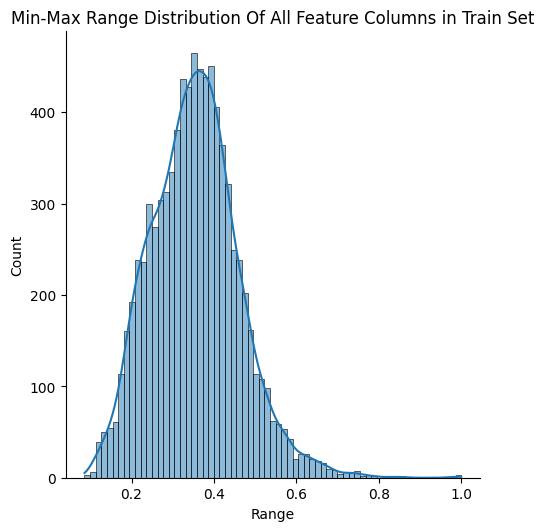

In [13]:
diff = diff.flatten()

sns.displot(diff, kde=True)
plt.ylabel('Count')
plt.xlabel('Range')
plt.title('Min-Max Range Distribution Of All Feature Columns in Train Set')

# **Testing Set Preparation**

In [14]:
df_test = pd.read_csv("/content/drive/MyDrive/HocMayThongKe/Project/Preprocessed Dataset/df_test.csv")
df_test

,comment,GENERAL,SCREEN,CAMERA,FEATURES,BATTERY,PERFORMANCE,STORAGE,DESIGN,PRICE,SER&ACC,OTHERS
0,"Điện thoải ổn. Facelock cực nhanh, vân tay ôk ...",1,1,0,1,0,1,0,0,0,0,0
1,"Mình mới mua vivo91c. Tải ứng dụng ,games nh...",0,0,0,-1,0,1,0,0,0,1,1
2,Xấu đẹp gì ko biết nhưng rất ưng TGdđ phục vụ ...,0,0,0,0,0,0,0,0,0,1,0
3,Màn hình hơi lác khi chơi game. Game nặng thì ...,0,0,0,0,0,-1,0,-1,0,0,1
4,"Nói chung máy đẹp với màn amoled, ổn trong tầm...",0,1,0,0,-1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2219,"Mẫu mã đẹp lung linh. Máy chạy cực nhanh, mượt...",0,0,0,1,0,1,0,1,0,0,1
2220,Có ai bị giống mình không máy thì sài bình thư...,0,0,0,0,0,-1,0,0,0,0,0
2221,Sản phẩm tốt 😊\nAi chơi game cứ mang 1 em về m...,1,0,0,0,0,1,0,0,0,0,0
2222,Vừa mới mua xong máy rất đẹp nhân viên rất nhi...,0,0,1,0,1,1,0,1,0,1,0


In [15]:
X_test_tok = dataframe_tokenize(df_test)
X_test_tok_enc = tfidf_vectorizer.transform(X_test_tok)
X_test_tok_enc.toarray().shape

(2224, 8381)

In [16]:
y_test = df_test.iloc[:, 1:]
y_test.shape

(2224, 11)

Text(0.5, 1.0, 'Min-Max Range Distribution Of All Feature Columns in Test Set')

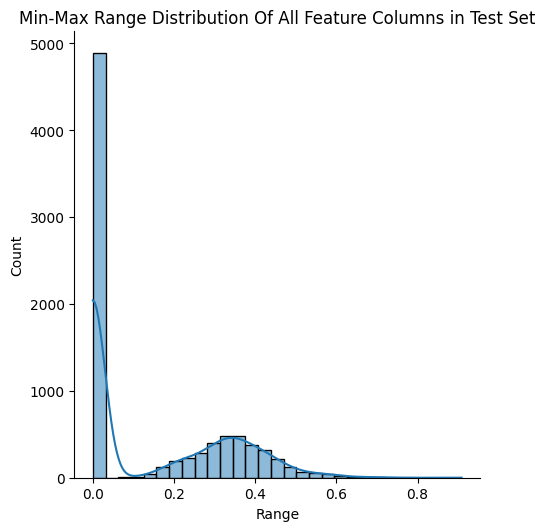

In [17]:
min_values = np.min(X_test_tok_enc, axis=0)
max_values = np.max(X_test_tok_enc, axis=0)
diff = max_values.toarray() - min_values.toarray() # alternative way, max_values.A - min_values.A

diff = diff.flatten()

sns.displot(diff, kde=True)
plt.ylabel('Count')
plt.xlabel('Range')
plt.title('Min-Max Range Distribution Of All Feature Columns in Test Set')

# **Dataset Statistic**

Text(0.5, 1.0, 'Statistics on the number of samples in training & testing set')

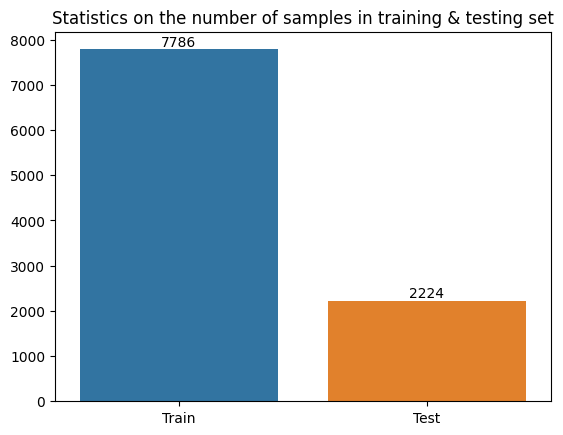

In [18]:
size = [df_train.shape[0], df_test.shape[0]]
ax = sns.barplot(x=['Train', 'Test'], y=size)

for i, v in enumerate(size):
    ax.text(i, v + 0.1, str(v), ha='center', va='bottom')

plt.title('Statistics on the number of samples in training & testing set')

In [19]:
# Training Data Frame Summary
dfSummary(df_train.iloc[:,1:])

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,GENERAL[int64],1. 12. 03. -1,"3,627 (46.6%)3,210 (41.2%)949 (12.2%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABlklEQVR4nO3bQWrbYBSF0aciQjORMAYvxovoYrsI7cYYa5CETNRBp20csLi/sM5ZwbP5sJHx7ZZlKUj40foA9qOrqteqeml9yIZ9Lsvy3vqIZ9Afj8dfwzAcWh+yVfM8X7uu+y24x/XDMBzO5/P7OI4frY/Zmtvt9nOapsPlcnmpKrE9qK+qGsfx43Q6vbU+ZqNeWx/wLDwgECM2YsRGjNiIERsxYiNGbMSIjRixESM2YsRGjNiIERsxYiOmr/r7v63Wh2yR92Vd/TzP12maDuV/W/80z/O1qj5b3/EMbBDus0FYSWfKR4pPNp9cMbtfV1lP5ex6XWU9lWVd5Sk8xo+6xIiNGLERIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IjZ9bpqr6+7ld2vq6yncmwQbBBirKuI8YBAzNpfo76S+K9Vp3xmcXxltSmfWRz3rD3l2+XPJ3yPBwRixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI0ZsxKw25TOL455Vp3xmcXzFBoEYUz5i/gBKvKNKS0O41wAAAABJRU5ErkJggg=="">",0(0.0%)
2,SCREEN[int64],1. 02. 13. -1,"6,893 (88.5%)514 (6.6%)379 (4.9%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABlElEQVR4nO3bQUrDUBiF0T9SRCcJpdDFdBEu1kVkN6U0AxUnceBcI3ncSnPOAsIbfDS8ktvN81yQ8HDrA7AdXVU9V9XjrQ/Cv/Y5z/P72ofsDofDS9/3+xYn4j5N03Tpuu51bXC7vu/3p9PpfRiGj1aH435cr9encRz35/P5sarWxVZVNQzDx/F4fGtyOu7Rc4uHuCAQIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI2ZX9f3N0q0Pwv/Uso3dNE2XcRz31eibJe7PNE2Xqvpc+xwbBJZoskHoTPlI+csvW5O62a7F66pWCxu2a9G6quXChu36y7rKbZVV/KlLjNiIERsxYiNGbMSIjRixESM2YsRGjNiIERsxYiNGbMSIjZhF6yrrK1pYvK5qtbBhu2wQiLGuIsYFgZglr1GvT5r4dcpnwkcrP075TPhoacmUz4SPJlwQiBEbMWIjRmzEiI0YsREjNmLERozYiBEbMWIjRmzEiI0YsRHz45TPhI+Wfp3ymfDRig0CMaZ8xHwBSryjShsbZNcAAAAASUVORK5CYII="">",0(0.0%)
3,CAMERA[int64],1. 02. 13. -1,"5,928 (76.1%)1,231 (15.8%)627 (8.1%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABmElEQVR4nO3bQWrbYBSF0adiQjORMAYvxovoYrsI7cYYa5CETJRBJ6EzK8r9f9pzVvDAn21kfId1XQsSfrQ+gP/HUFXPVfXU+hB2976u62vrIz47nE6nX+M4Hlsfwr6WZbkNw/C7p+AO4zgeL5fL6zRNb62PYR/3+/3nPM/H6/X6VFX9xFZVNU3T2/l8fml9DLt6bn3A3zwgECM2YsRGjNiIERsxYiNGbMSIjRixESM2YsRGjNiIERsxYiPmUPXn/0+tD2E/vb6eh2VZbvM8H6vD/z+x3bIst6p6b33HZzYI/67uNgiDKR8pqU+27t5l5EXWVT0ufcj79nVVr0sf8lLrKk+6+FGXHLERIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzHfvq7qdelDXmRd1ePShzwbBGKsq4jxgEDMlq9RX4ls8vCUzyyPrR6a8pnl8RVbpnxmeWziAYEYsREjNmLERozYiBEbMWIjRmzEiI0YsREjNmLERozYiBEbMQ9N+czy+IqHp3xmeWxlg0CMKR8xH0q8o0rA5ZlRAAAAAElFTkSuQmCC"">",0(0.0%)
4,FEATURES[int64],1. 02. -13. 1,"5,342 (68.6%)1,659 (21.3%)785 (10.1%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABnklEQVR4nO3bQW7aYBSF0ecKRc3EFkJiMSyii+0ivBuE8CCJMnEHnbYxkaP7g3POCp7EB8iI283zXJDwo/UBfB9dVT1X1VPrQ1j0Ps/za+sj1tgdDodffd/vWx/Cx6ZpunRd9/uRg9v1fb8/nU6vwzC8tT6Gf7terz/Hcdyfz+enqnrc2KqqhmF4Ox6PL62P4UPPrQ9YywMCMWIjRmzEiI0YsREjNmLERozYiBEbMWIjRmzEiI0YsREjNmJ2VX//L9X6EP5vK6/PbpqmyziO+9rA/6W2bJqmS1W9t75jDRuEx/HwG4TOlI+Ue/lke/h3LcvuYl21heUQy5qvq7ayHGLZvayrPAl/A37UJUZsxIiNGLERIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZixEZM83XVVpZDLLuLddUWlkMss0EgxrqKGA8IxHzF16ivQG6yespnhsetVk35zPD4jK+Y8pnhcRMPCMSIjRixESM2YsRGjNiIERsxYiNGbMSIjRixESM2YsRGjNiIWTXlM8PjM1ZP+czwuJUNAjGmfMT8AUq8o0r0cr6oAAAAAElFTkSuQmCC"">",0(0.0%)
5,BATTERY[int64],1. 02. 13. -1,"4,531 (58.2%)2,027 (26.0%)1,228 (15.8%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABlUlEQVR4nO3bwWnjYBSF0afBhGQjYQwuxkVMsVOEujHGWiQhG2URAlkP+P7Kr3MqeJgPGwnfYV3XgoQ/rQ9gP4aqeqmqp9aH7MDHuq5vrY9o6XA6nf6O43hsfUjvlmW5DcPwb8/BHcZxPF4ul7dpmt5bH9Or+/3+PM/z8Xq9PlXVfmOrqpqm6f18Pr+2PqZzL60PaM0DAjFiI0ZsxIiNGLERIz

In [20]:
# Testing Data Frame Summary
dfSummary(df_test.iloc[:,1:])

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,GENERAL[int64],1. 12. 03. -1,"1,004 (45.1%)926 (41.6%)294 (13.2%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABlklEQVR4nO3bQWrqABSF4ZtHkHaSIIKLcRFd7FtEdiNiBq+lk7yBo0J1FE+C+b4VXOVHiXiaaZoKEv4sfQDb0VTVe1Xtlj5khb6nafpc+ohX0h4Oh4+u6/ZLH7I24zhemqb5K7j5tF3X7U+n02ff919LH7MW1+v1bRiG/fl83lWV2GbSVlX1ff91PB7/LX3MyrwvfcCr8YBAjNiIERsxYiNGbMSIjRixESM2YsRGjNiIERsxYiNGbMSIjZi26vb/raUPWRPvx3O04zhehmHYl/9v/TCO46Wqvpe+45XYINxngzCzxpSPFJ9sNz7FAqyrypIqZfPrKkuqHOuqG0/iAX7UJUZsxIiNGLERIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZixEbM5tdVW37tadZVZUmVYoNwY4MQYF1FjAcEYp7xNeoriV/NPuUzi+OeWad8ZnE88owp32Z/QuExDwjEiI0YsREjNmLERozYiBEbMWIjRmzEiI0YsREjNmLERozYiJl1ymcWxyOzT/nM4rjHBoEYUz5i/gNKvKNKeqLeDAAAAABJRU5ErkJggg=="">",0(0.0%)
2,SCREEN[int64],1. 02. 13. -1,"1,972 (88.7%)136 (6.1%)116 (5.2%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABk0lEQVR4nO3bQUrDUBiF0T9SRCcJpdDFdBEu1kVkN6U0AxUnceDcBvK4leacBYQ3+Gh4Jbeb57kg4eneB2A7uqp6rarnex+Ef+17nufPtQ/ZHQ6Ht77v9y1OxGOapunSdd372uB2fd/vT6fT5zAMX60Ox+O4Xq8v4zjuz+fzc1Wti62qahiGr+Px+NHkdDyi1xYPcUEgRmzEiI0YsREjNmLERozYiBEbMWIjRmzEiI0YsREjNmLERsyu6vebpXsfhP+pZRu7aZou4zjuq9E3SzyeaZouVfW99jk2CCzRZIPQmfKRsvSXrUnZbNuidVWrdQ3bdnNd1XJdw7YtXVe5qbKaP3WJERsxYiNGbMSIjRixESM2YsRGjNiIERsxYiNGbMSIjRixEXNzXWV5RSuL1lWt1jVsmw0CMdZVxLggELPkNeoVShM3p3xmfLTy55TPjI+Wlkz5zPhowgWBGLERIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzF/TvnM+Gjp5pTPjI9WbBCIMeUj5gfWeKNKQUoTegAAAABJRU5ErkJggg=="">",0(0.0%)
3,CAMERA[int64],1. 02. 13. -1,"1,707 (76.8%)346 (15.6%)171 (7.7%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABnElEQVR4nO3bQWoiYRSF0VeNhM6kChFcjIvoxfYiajci1iAJmVQGTaCnlnr/n+5zVvDAT6XEO6zrWpDwo/UB/D+GqnqtqpfWh/AUn+u6vrc+4tvucDj8Gsdx3/oQHm9ZlsswDL97CW43juP+dDq9T9P00foYHud6vf6c53l/Pp9fqqqP2Kqqpmn6OB6Pb62P4eFeWx/wNw8IxIiNGLERIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IjZVf3571PrQ3isHl/T3bIsl3me99XZf5+437Isl6r6bH3HNxuEf1tXG4TBlI+UxCdbV+8u2nn6uqq3hQ/tPHVd1ePCh3YS6ypPuVSVH3UJEhsxYiNGbMSIjRixESM2YsRGjNiIERsxYiNGbMSIjRixEfPUdVWPCx/aefq6qreFD+3YIBBjXUWMBwRitnyN+lpkk5unfKZ5bHXTlM80j3tsmfKZ5rGJBwRixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI0ZsxNw05TPN4x43T/lM89jKBoEYUz5ivgBKvKNKOIK9wQAAAABJRU5ErkJggg=="">",0(0.0%)
4,FEATURES[int64],1. 02. -13. 1,"1,565 (70.4%)459 (20.6%)200 (9.0%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABmklEQVR4nO3bUWoiQRiF0epBwuSlGxFcjIvIYmcRvRsR62ES8tLzMAuI1YFbKTxnBT/4qbR4p23bCiT86n0Az2MqpbyWUl56H0KTz23b3nsf0epwOp3e5nk+9j6Ex9Vab9M0/RktuMM8z8fL5fK+LMtH72P42v1+/72u6/F6vb6UUsaKrZRSlmX5OJ/Pf3sfw8Neex+whwcEYsRGjNiIERsxYiNGbMSIjRixESM2YsRGjNiIERsxYiNGbMQcSvn/H6neh/CYkV+rQ631tq7rsQz6H6lnVGu9lVI+e9/RygZhTENuECZTPlJ+wifbkO9S2nVfV426FKJd13XVyEsh2v2EdZWn4CfhR11ixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI0ZsxHRdV428FKJd93XVqEsh2tkgEGNdRYwHBGK+8zXq648mu6d8Jni02jXlM8Fjj+9M+UzwaOIBgRixESM2YsRGjNiIERsxYiNGbMSIjRixESM2YsRGjNiIERsxu6Z8JnjssXvKZ4JHKxsEYkz5iPkHSryjSi8JiAsAAAAASUVORK5CYII="">",0(0.0%)
5,BATTERY[int64],1. 02. 13. -1,"1,302 (58.5%)554 (24.9%)368 (16.5%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABjklEQVR4nO3bwWnDQBgF4acgTHyREAYX4yJSbIpQN8J4D7HxRTmkhMDsop2vgh8z2Ej4Dfu+RyJ81D5A/RiSnJOcah/Sife+78/aR9QyXi6Xr2maltqH9KCUch+G4bvX4MZpmpbb7fac5/lV+5gjezwen+u6Ltu2nZL0GVuSzPP8ul6vP7WP6cC59gE1+YAgjLEJY2zCGJswxiaMsQljbMIYmzDGJoyxC

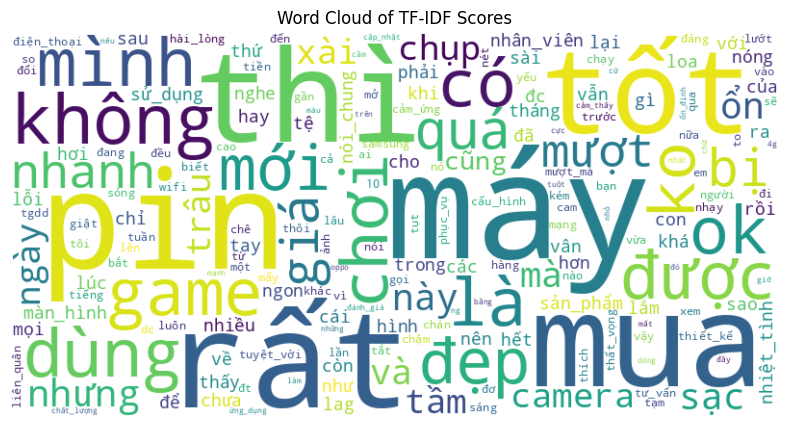

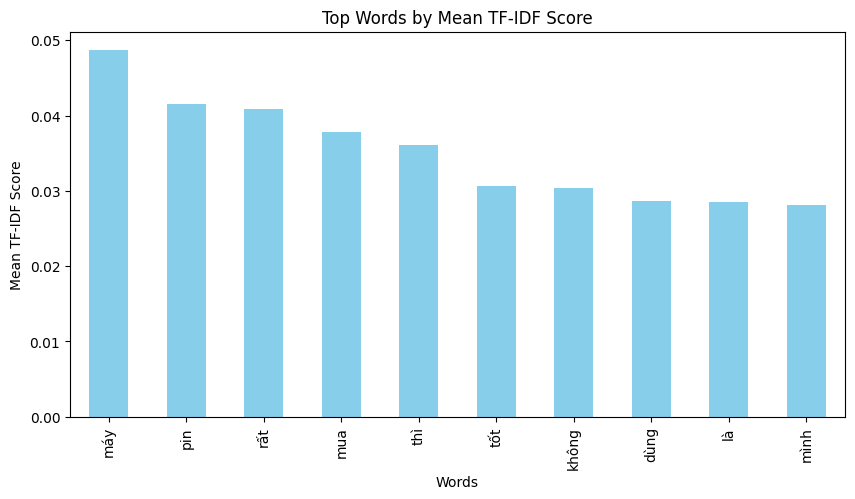

In [21]:
from wordcloud import WordCloud
feature_names = tfidf_vectorizer.get_feature_names_out()

# Create a DataFrame with TF-IDF scores
df_tfidf_train = pd.DataFrame(data=X_train_tok_enc.toarray(), columns=feature_names)

# Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(df_tfidf_train.sum().to_dict())

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of TF-IDF Scores')
plt.show()

# Bar Chart
mean_tfidf = df_tfidf_train.mean().sort_values(ascending=False)
top_words = mean_tfidf.head(10)  # Adjust the number of top words as needed

plt.figure(figsize=(10, 5))
top_words.plot(kind='bar', color='skyblue')
plt.xlabel('Words')
plt.ylabel('Mean TF-IDF Score')
plt.title('Top Words by Mean TF-IDF Score')
plt.show()

In [22]:
def visualize_top_frequent_word(class_name):
  class_val = None
  if class_name == "Positive":
    class_val = 1
  elif class_name == "Nagative":
    class_val = -1
  else:
    class_val = 0

  # Number of aspect_cols
  num_aspect_cols = len(aspect_cols)

  # Calculate the number of rows needed based on two columns per row
  num_rows = (num_aspect_cols + 1) // 2

  # Create a subplot grid with two columns
  fig, axes = plt.subplots(num_rows, 2, figsize=(15, 4 * num_rows))

  # Loop through each aspect column
  for i, col in enumerate(aspect_cols):
      # Calculate row and column index for the subplot
      row_index = i // 2
      col_index = i % 2

      # Select rows where col == 1 and extract comments
      selected_rows = df_train[df_train[col] == class_val]['comment']

      # Split comments into words and count frequencies
      lst = [word for row in selected_rows for word in row.split(' ')]
      word_counts = Counter(lst)

      # Select top N words
      top_n = 10
      top_words = dict(word_counts.most_common(top_n))

      # Plot bar chart in the (row_index, col_index)-th subplot
      axes[row_index, col_index].bar(top_words.keys(), top_words.values())
      axes[row_index, col_index].set_title(f'Top {top_n} Most Frequent Words in {class_name} {col} Comments')
      axes[row_index, col_index].set_xlabel('Words')
      axes[row_index, col_index].set_ylabel('Frequency')

  # Remove empty subplots if the number of aspect_cols is odd
  if num_aspect_cols % 2 == 1:
      fig.delaxes(axes[-1, -1])

  # Automatically adjust layout
  plt.tight_layout()
  plt.show()

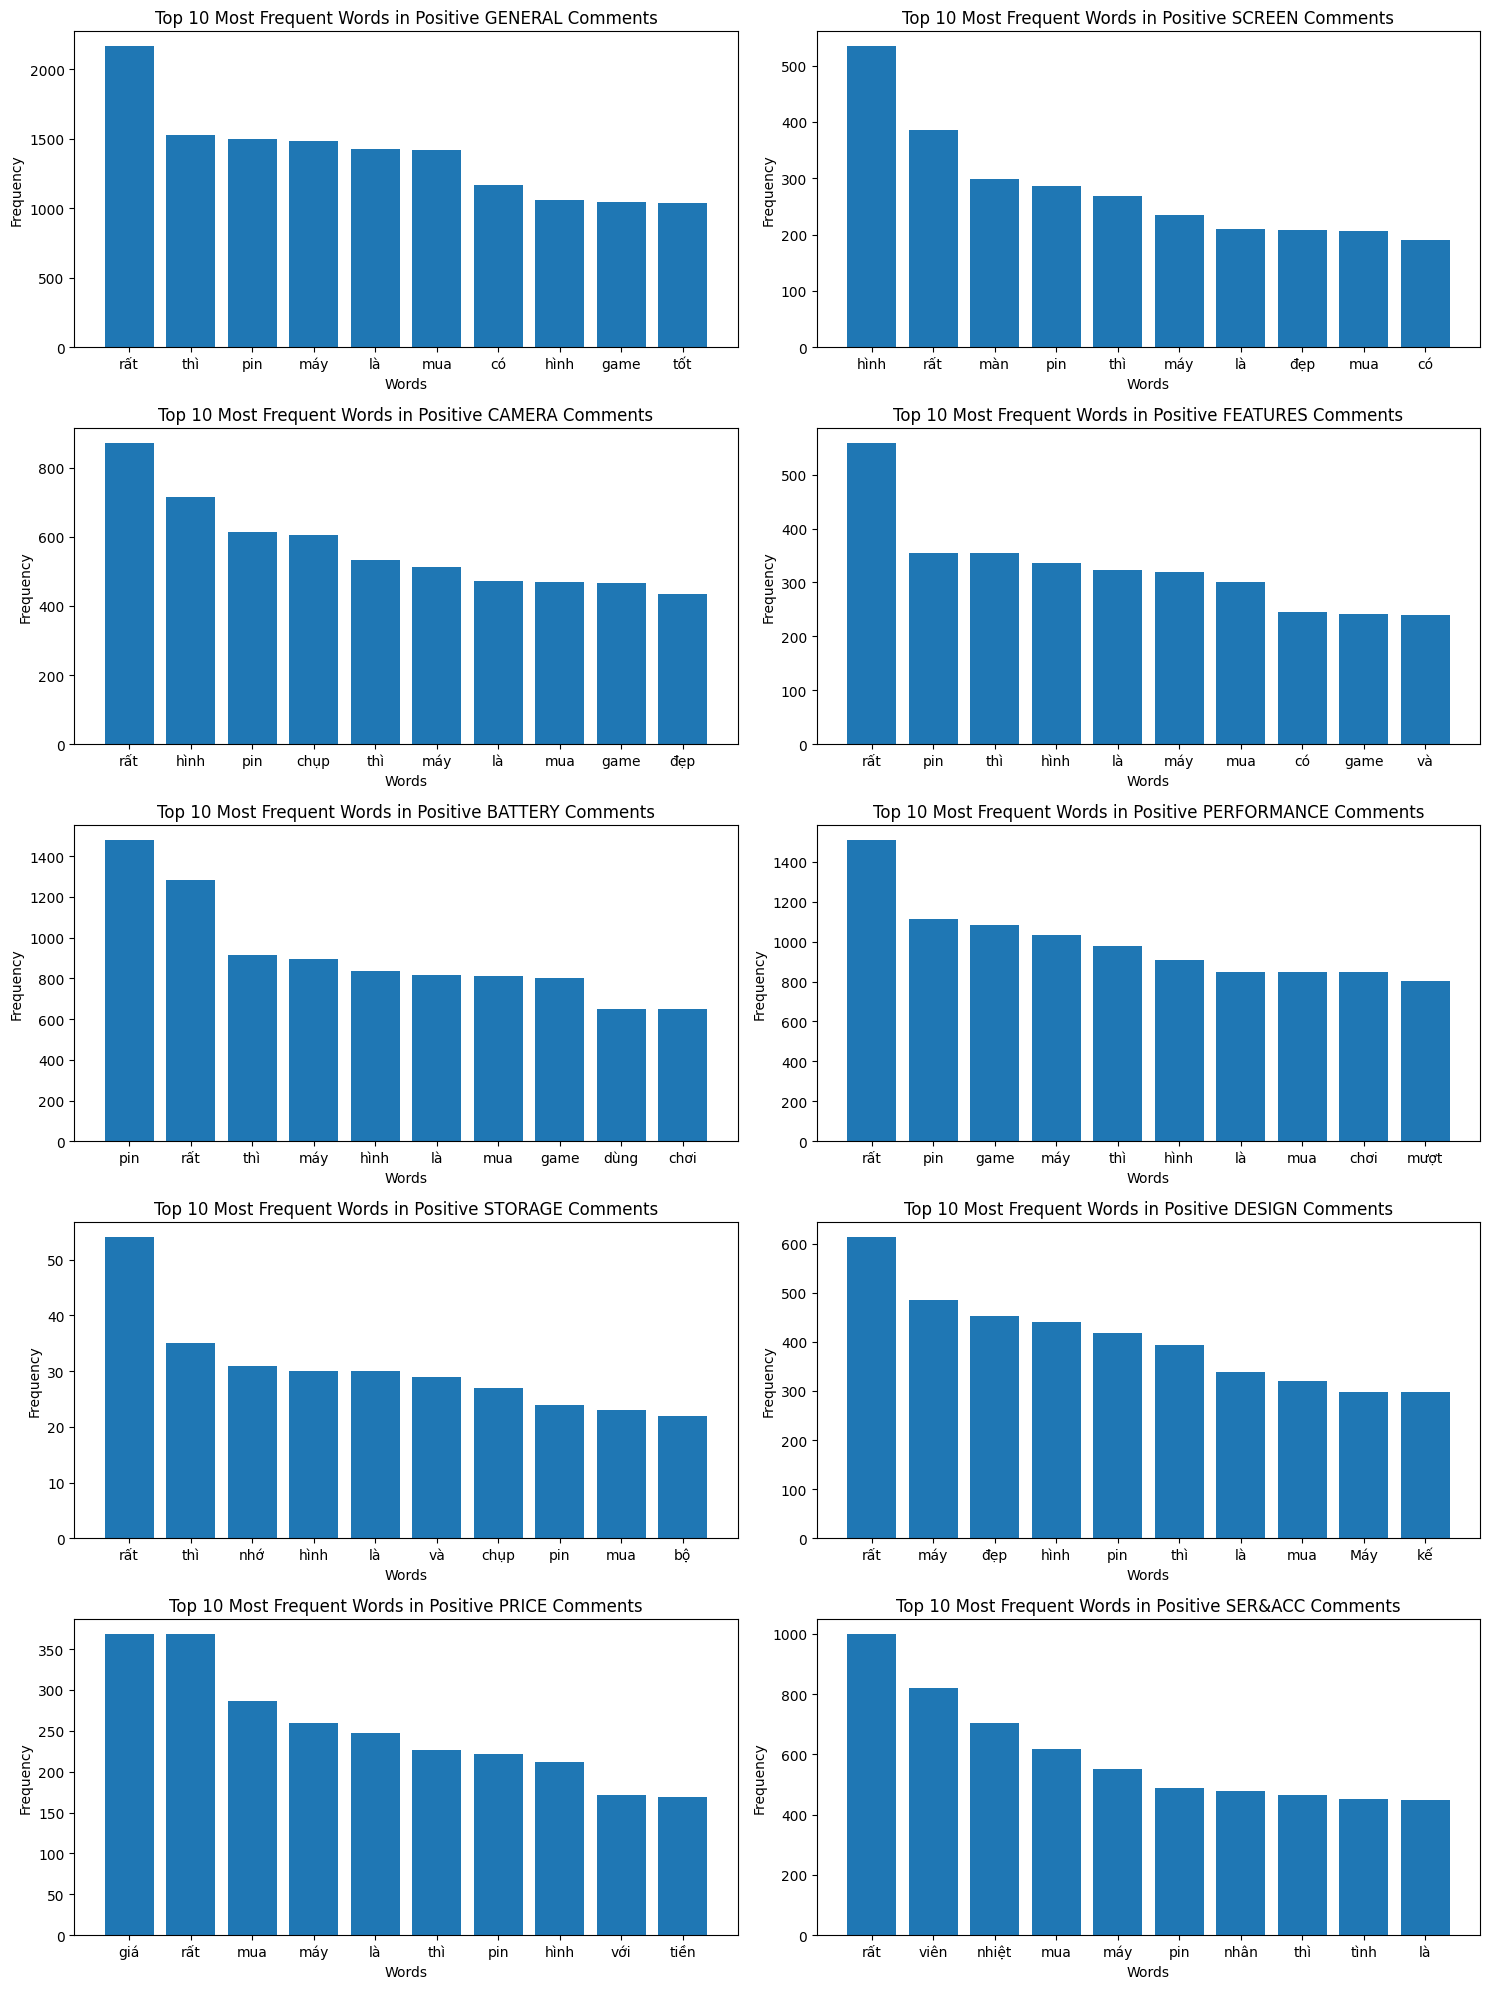

In [23]:
visualize_top_frequent_word("Positive")

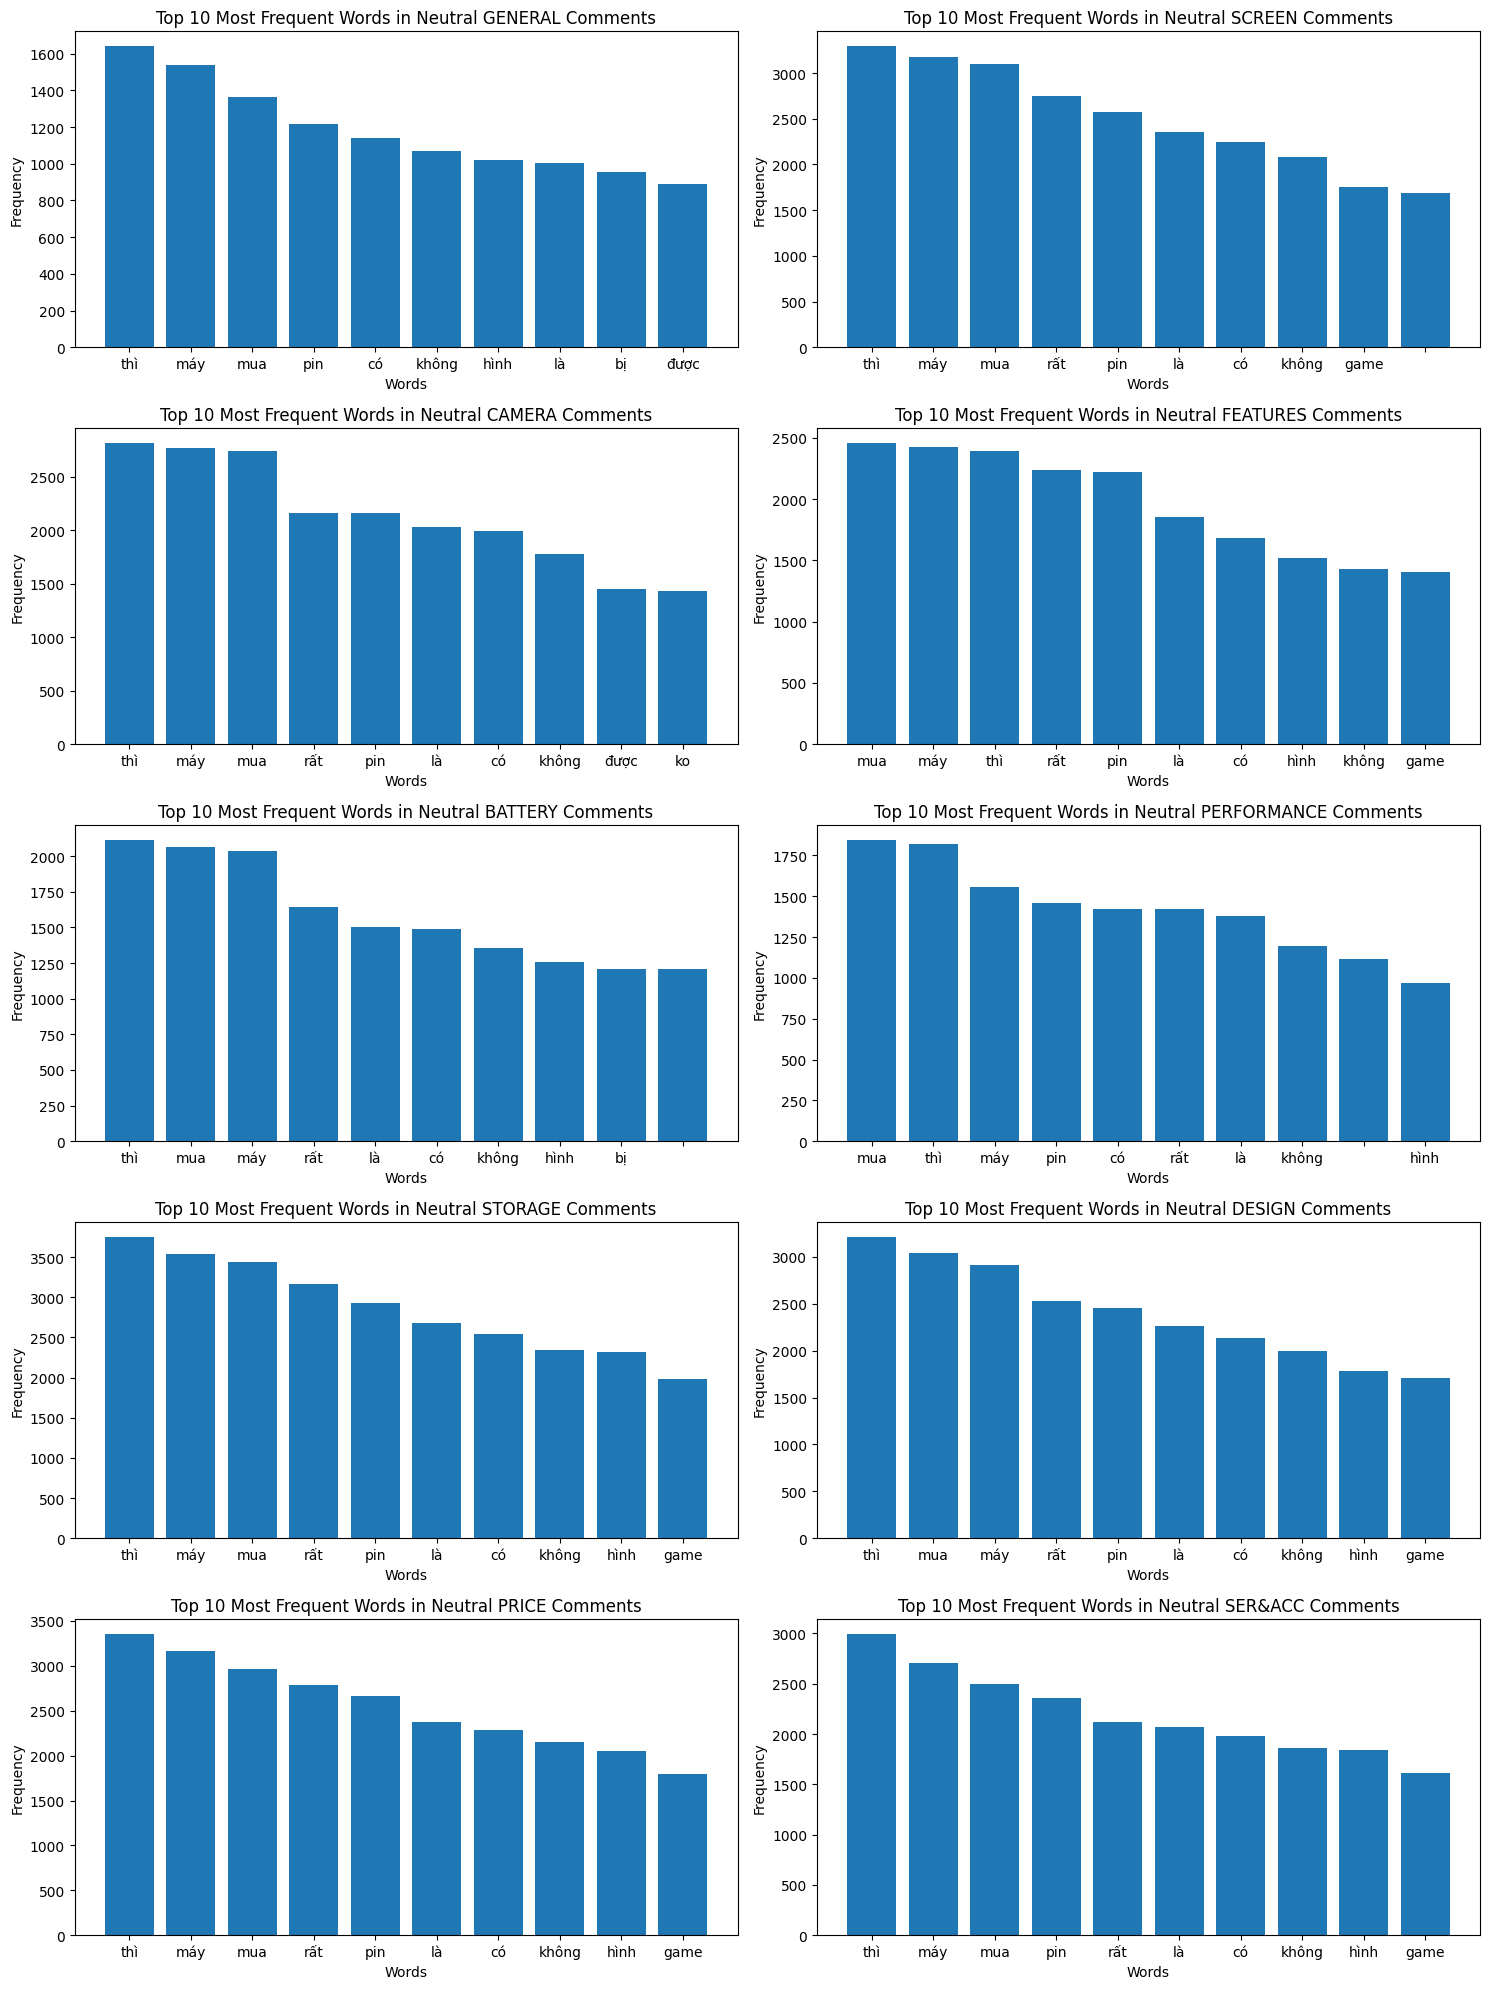

In [24]:
visualize_top_frequent_word("Neutral")

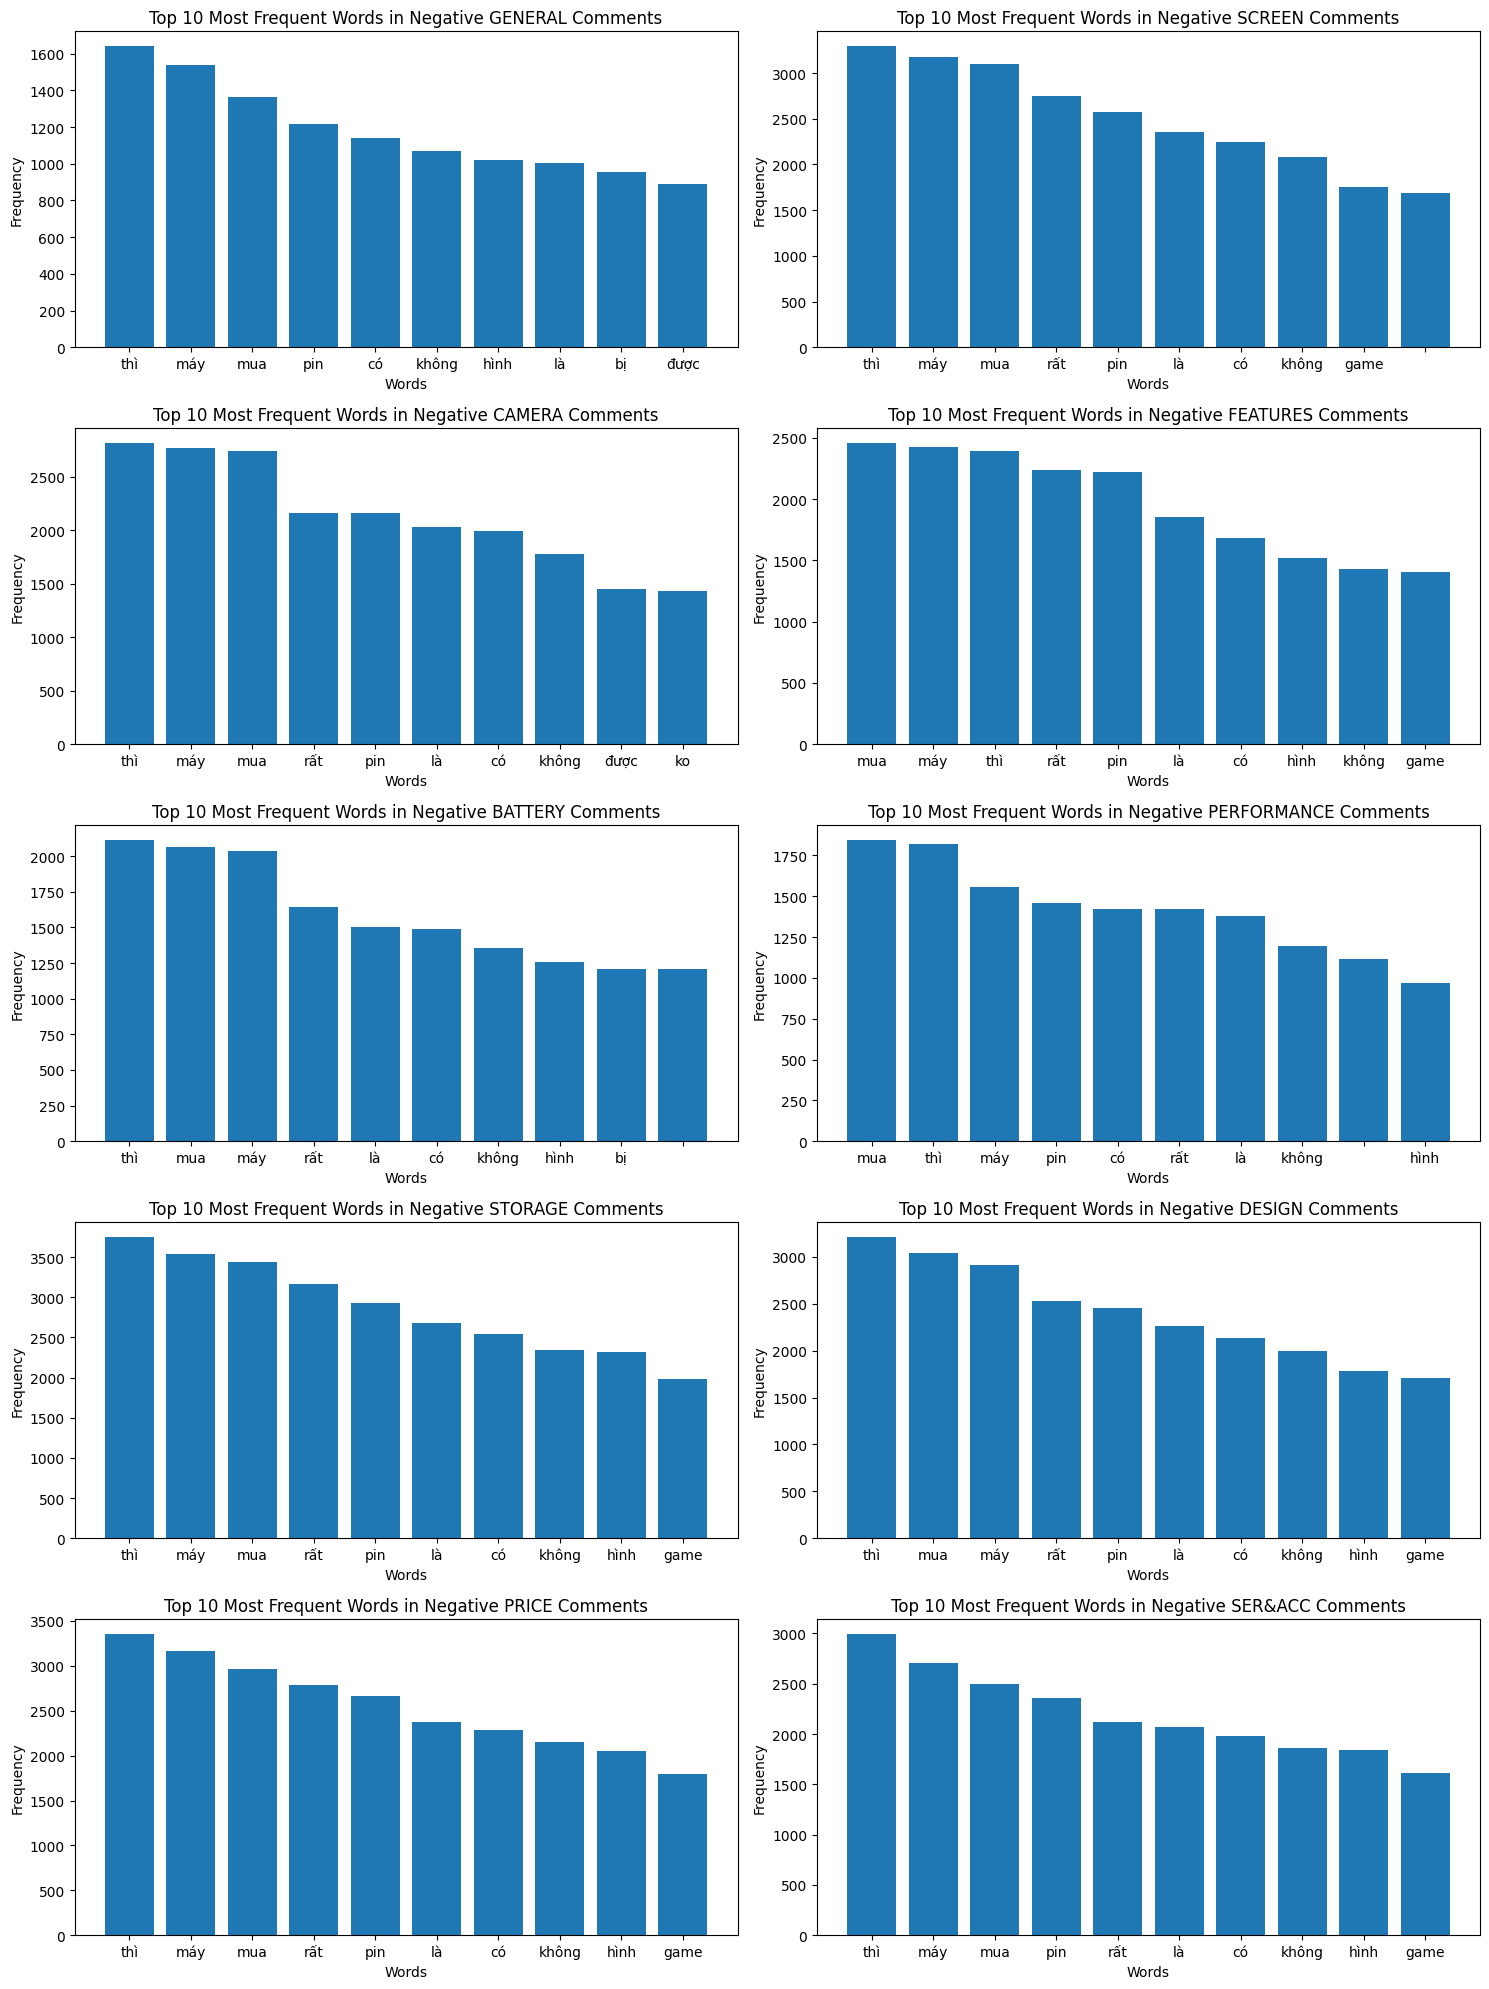

In [25]:
visualize_top_frequent_word("Negative")

Text(0, 0.5, 'Explained Variance Ratio')

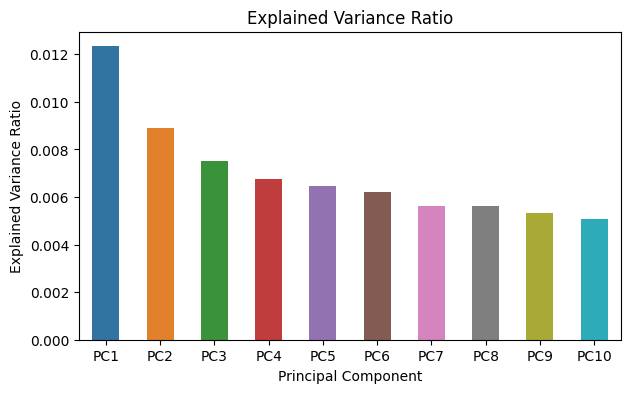

In [26]:
# Plot bar chart for explained variance ratio

pca_tmp = PCA(n_components=10)
x_tmp = pca_tmp.fit_transform(X_train_tok_enc.A)

plt.figure(figsize=(7, 4))
sns.barplot(x=['PC'+str(i) for i in range(1, 11)], y=pca_tmp.explained_variance_ratio_, width=0.5)
plt.title('Explained Variance Ratio')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')

In [27]:
# obtain 2 first principal components
pca = PCA(n_components=2)

X_train_pca = pca.fit_transform(X_train_tok_enc.A)
X_test_pca = pca.fit_transform(X_test_tok_enc.A)

In [28]:
# Number of subplots
X = 11

# Calculate the number of rows needed based on two columns per row
num_rows = (X + 1) // 2

# Create a subplot grid with two columns
fig, axes = plt.subplots(num_rows, 2, figsize=(12, 4 * num_rows))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each subplot
for i, (ax, col) in enumerate(zip(axes, aspect_cols+['OTHERS'])):
    # Your Seaborn scatter plot code goes here
    sns.scatterplot(x=X_train_pca[:, 0], y=X_train_pca[:, 1], hue=df_train[col], ax=ax)

    # Set title for the subplot
    ax.set_title(f'Subplot of {col}')

# Remove empty subplots if the number of X is odd
if X % 2 == 1:
    fig.delaxes(axes[-1])

# Automatically adjust layout
plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [29]:
# lengths_train = [len(cmt) for cmt in df_train['comment']]

# plt.figure(figsize=(10, 6))
# sns.histplot(lengths_train, bins=30, kde=True)

# plt.title('Distribution of comment lengths on train set')
# plt.xlabel('Length of comments')
# plt.ylabel('Number of comments')
# plt.show()

In [30]:
# import statistics as st

# print(f'Mean of comments length in train set:     {np.mean(lengths_train).round(2)}')
# print(f'Mode of comments length in train set:     {st.mode(lengths_train)}')
# print(f'Variance of comments length in train set: {np.var(lengths_train).round(2)}')

In [31]:
# lengths_test = [len(cmt) for cmt in df_test['comment']]

# plt.figure(figsize=(10, 6))
# sns.histplot(lengths_test, bins=30, kde=True)

# plt.title('Distribution of comment lengths on test set')
# plt.xlabel('Length of comments')
# plt.ylabel('Number of comments')
# plt.show()

In [32]:
# print(f'Mean of comments length in train set:     {np.mean(lengths_test).round(2)}')
# print(f'Mode of comments length in train set:     {st.mode(lengths_test)}')
# print(f'Variance of comments length in train set: {np.var(lengths_test).round(2)}')

In [33]:
# lbl_cols_train = df_train.columns[1:]

# plt.figure(figsize=(8, 6))

# # Calculate the correlation matrix
# corr_matrix_train = df_train[lbl_cols_train].corr()
# sns.heatmap(corr_matrix_train, annot=True, cmap='coolwarm', linewidths=.5)
# plt.title('Correlation Matrix of Labels on Train Set')

In [34]:
# sns.histplot(corr_matrix_train.values.flatten(), kde=True)

# **Training and Evaluation**

In [49]:
evaluation_cols = aspect_cols + ['OTHERS']
evaluation_cols

['GENERAL',
 'SCREEN',
 'CAMERA',
 'FEATURES',
 'BATTERY',
 'PERFORMANCE',
 'STORAGE',
 'DESIGN',
 'PRICE',
 'SER&ACC',
 'OTHERS']

In [50]:
models = ['Logistic Regression','Softmax', 'SVM']

model_scores = []         # save score without PCA
model_scores_pca = []     # save score with PCA

In [51]:
def evaluate(y_test, y_pred):
    scores = []
    for i, col in enumerate(y_test.columns):
        score = accuracy_score(y_test[col].values, y_pred[:,i])
        scores.append(score)
        print(f'accuracy on {col.ljust(14)} {score}')

    return scores

In [52]:
def compare_models(df_evaluation):
  # Create a figure with a 3x4 grid of subplots
  fig, axes = plt.subplots(3, 4, figsize=(20, 12))

  # Flatten the 2D array of subplots to simplify indexing
  axes = axes.flatten()

  # Plot on each subplot
  for i, col in enumerate(df_evaluation.columns):
      ax = sns.barplot(x=models, y=df_evaluation[col], ax=axes[i], width=0.5)

      # Set y-axis limits from 0 to 1 for each subplot
      ax.set_ylim(0, 1.05)

      for j, v in enumerate(df_evaluation[col]):
          ax.text(j, v + 0.0001 * ax.get_ylim()[1], str(v), ha='center', va='bottom', fontsize=10)

      ax.set_title(f'{col}')

      # Change the y-axis label
      ax.set_ylabel('accuracy')

  # Hide empty subplots if there are fewer subplots than the total number of subplots
  for i in range(len(evaluation_cols), 3 * 4):
      axes.flatten()[i].axis('off')

  # Adjust layout to prevent clipping of titles and labels
  plt.tight_layout()

  # Show the plot
  plt.show()

## Training without PCA

### Logistic Regression

In [53]:
base_LogRes = LogisticRegression(multi_class='ovr', solver='sag', max_iter=1000)

LogRes_classifier = MultiOutputClassifier(base_LogRes, n_jobs=-1)

LogRes_classifier.fit(X_train_tok_enc, y_train)

MultiOutputClassifier(estimator=LogisticRegression(max_iter=1000,
                                                   multi_class='ovr',
                                                   solver='sag'),
                      n_jobs=-1)

In [54]:
y_pred = LogRes_classifier.predict(X_test_tok_enc)
model_scores.append(evaluate(y_test, y_pred))

accuracy on GENERAL        0.7473021582733813
accuracy on SCREEN         0.9096223021582733
accuracy on CAMERA         0.8637589928057554
accuracy on FEATURES       0.8282374100719424
accuracy on BATTERY        0.8138489208633094
accuracy on PERFORMANCE    0.7679856115107914
accuracy on STORAGE        0.9892086330935251
accuracy on DESIGN         0.8799460431654677
accuracy on PRICE          0.908273381294964
accuracy on SER&ACC        0.8628597122302158
accuracy on OTHERS         0.7814748201438849


### Softmax

In [55]:
base_softmax = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)

softmax_classifier = MultiOutputClassifier(base_softmax, n_jobs=-1)

softmax_classifier.fit(X_train_tok_enc, y_train)

MultiOutputClassifier(estimator=LogisticRegression(max_iter=1000,
                                                   multi_class='multinomial'),
                      n_jobs=-1)

In [56]:
y_pred = softmax_classifier.predict(X_test_tok_enc)
model_scores.append(evaluate(y_test, y_pred))

accuracy on GENERAL        0.7459532374100719
accuracy on SCREEN         0.9181654676258992
accuracy on CAMERA         0.8812949640287769
accuracy on FEATURES       0.83318345323741
accuracy on BATTERY        0.8295863309352518
accuracy on PERFORMANCE    0.77068345323741
accuracy on STORAGE        0.9892086330935251
accuracy on DESIGN         0.8848920863309353
accuracy on PRICE          0.9154676258992805
accuracy on SER&ACC        0.8691546762589928
accuracy on OTHERS         0.7819244604316546


### SVM

In [57]:
tmp_svm = SVC(decision_function_shape='ovr', kernel='rbf')
tmp_svm.fit(X_train_tok_enc, y_train.values[:,1])

SVC()

In [58]:
base_svm = SVC(decision_function_shape='ovr')

svm_classifier = MultiOutputClassifier(base_svm, n_jobs=-1)

svm_classifier.fit(X_train_tok_enc, y_train.values)

MultiOutputClassifier(estimator=SVC(), n_jobs=-1)

In [59]:
y_pred = svm_classifier.predict(X_test_tok_enc)
model_scores.append(evaluate(y_test, y_pred))

accuracy on GENERAL        0.7504496402877698
accuracy on SCREEN         0.9100719424460432
accuracy on CAMERA         0.8790467625899281
accuracy on FEATURES       0.83318345323741
accuracy on BATTERY        0.8376798561151079
accuracy on PERFORMANCE    0.7702338129496403
accuracy on STORAGE        0.9892086330935251
accuracy on DESIGN         0.887589928057554
accuracy on PRICE          0.91681654676259
accuracy on SER&ACC        0.8687050359712231
accuracy on OTHERS         0.7769784172661871


## Evaluation without PCA

In [60]:
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: #fdff99' if v else '' for v in is_max]

In [61]:
df_evaluation = pd.DataFrame(data=model_scores, index=models, columns=evaluation_cols).round(3)
df_evaluation_styled = df_evaluation.style.apply(highlight_max)
df_evaluation_styled

,GENERAL,SCREEN,CAMERA,FEATURES,BATTERY,PERFORMANCE,STORAGE,DESIGN,PRICE,SER&ACC,OTHERS
Logistic Regression,0.747000,0.910000,0.864000,0.828000,0.814000,0.768000,0.989000,0.880000,0.908000,0.863000,0.781000
Softmax,0.746000,0.918000,0.881000,0.833000,0.830000,0.771000,0.989000,0.885000,0.915000,0.869000,0.782000
SVM,0.750000,0.910000,0.879000,0.833000,0.838000,0.770000,0.989000,0.888000,0.917000,0.869000,0.777000


In [62]:
print(f"Mean of Softmax accuracy score:   {np.mean(df_evaluation.loc['Logistic Regression'].values)}")
print(f"Mean of Softmax accuracy score:   {np.mean(df_evaluation.loc['Softmax'].values)}")
print(f"Mean of SVM accuracy score:       {np.mean(df_evaluation.loc['SVM'].values)}")

Mean of Softmax accuracy score:   0.8501818181818183
Mean of Softmax accuracy score:   0.8562727272727273
Mean of SVM accuracy score:       0.8563636363636363


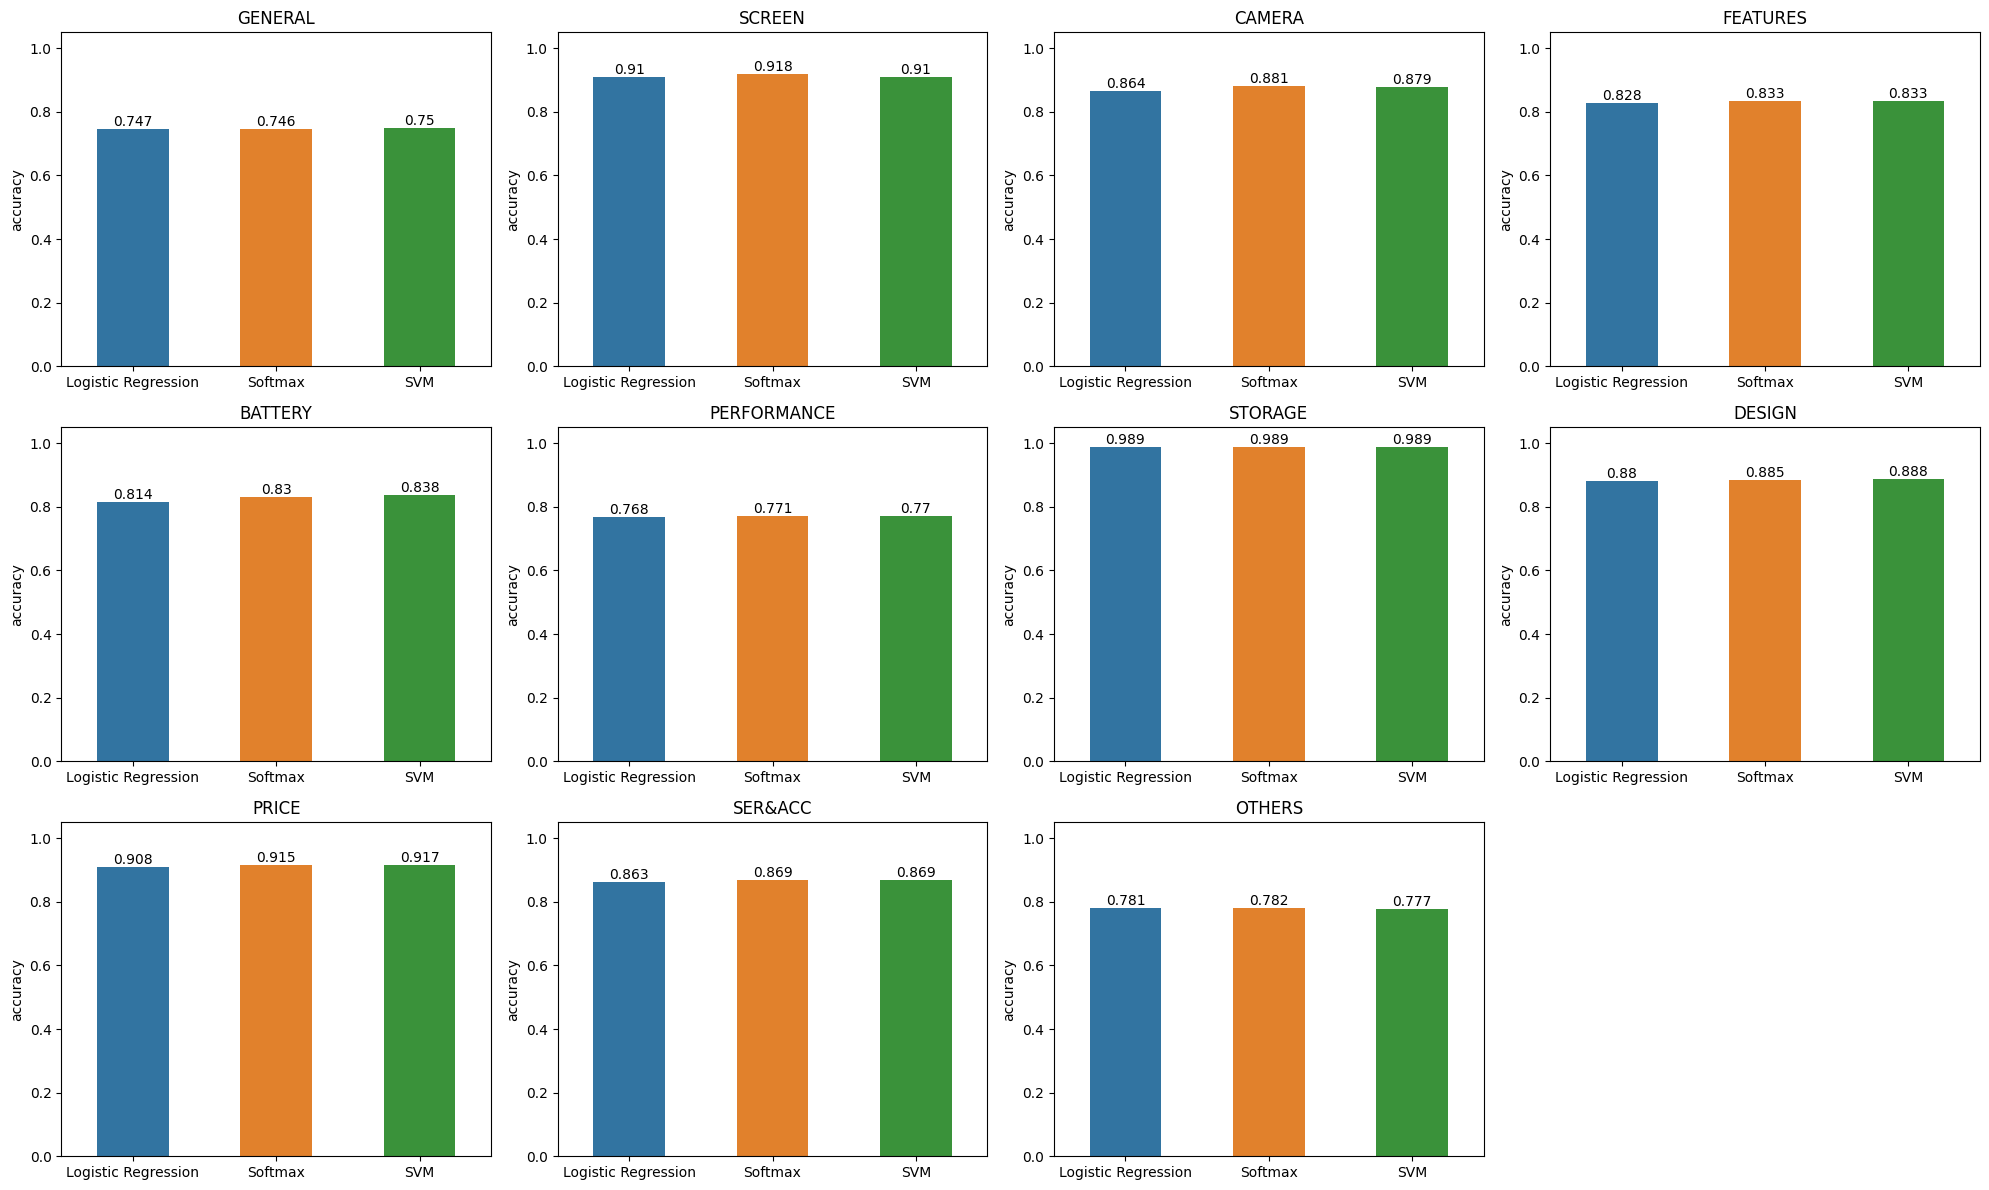

In [63]:
compare_models(df_evaluation)

## Training with PCA

### Logistic Regression

In [64]:
base_LogRes_pca = LogisticRegression(multi_class='ovr', solver='sag', max_iter=1000)

LogRes_classifier_pca = MultiOutputClassifier(base_LogRes_pca, n_jobs=-1)

LogRes_classifier_pca.fit(X_train_pca, y_train)

MultiOutputClassifier(estimator=LogisticRegression(max_iter=1000,
                                                   multi_class='ovr',
                                                   solver='sag'),
                      n_jobs=-1)

In [65]:
y_pred = LogRes_classifier_pca.predict(X_test_pca)
model_scores_pca.append(evaluate(y_test, y_pred))

accuracy on GENERAL        0.6002697841726619
accuracy on SCREEN         0.8866906474820144
accuracy on CAMERA         0.7724820143884892
accuracy on FEATURES       0.7045863309352518
accuracy on BATTERY        0.6407374100719424
accuracy on PERFORMANCE    0.5935251798561151
accuracy on STORAGE        0.9892086330935251
accuracy on DESIGN         0.8264388489208633
accuracy on PRICE          0.891636690647482
accuracy on SER&ACC        0.779226618705036
accuracy on OTHERS         0.7693345323741008


### Softmax

In [66]:
base_softmax_pca = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)

softmax_classifier_pca = MultiOutputClassifier(base_softmax, n_jobs=-1)

softmax_classifier_pca.fit(X_train_pca, y_train)

MultiOutputClassifier(estimator=LogisticRegression(max_iter=1000,
                                                   multi_class='multinomial'),
                      n_jobs=-1)

In [67]:
y_pred = softmax_classifier_pca.predict(X_test_pca)
model_scores_pca.append(evaluate(y_test, y_pred))

accuracy on GENERAL        0.6011690647482014
accuracy on SCREEN         0.8866906474820144
accuracy on CAMERA         0.7702338129496403
accuracy on FEATURES       0.6996402877697842
accuracy on BATTERY        0.6407374100719424
accuracy on PERFORMANCE    0.595773381294964
accuracy on STORAGE        0.9892086330935251
accuracy on DESIGN         0.8241906474820144
accuracy on PRICE          0.8911870503597122
accuracy on SER&ACC        0.7778776978417267
accuracy on OTHERS         0.7693345323741008


### SVM

In [68]:
base_svm_pca = SVC(decision_function_shape='ovr')

svm_classifier_pca = MultiOutputClassifier(base_svm_pca, n_jobs=-1)

svm_classifier_pca.fit(X_train_pca, y_train.values)

MultiOutputClassifier(estimator=SVC(), n_jobs=-1)

In [69]:
y_pred = svm_classifier_pca.predict(X_test_pca)
model_scores_pca.append(evaluate(y_test, y_pred))

accuracy on GENERAL        0.6025179856115108
accuracy on SCREEN         0.8866906474820144
accuracy on CAMERA         0.7715827338129496
accuracy on FEATURES       0.7045863309352518
accuracy on BATTERY        0.6560251798561151
accuracy on PERFORMANCE    0.5993705035971223
accuracy on STORAGE        0.9892086330935251
accuracy on DESIGN         0.8336330935251799
accuracy on PRICE          0.891636690647482
accuracy on SER&ACC        0.7864208633093526
accuracy on OTHERS         0.7693345323741008


## Evaluation with PCA

In [70]:
df_evaluation_pca = pd.DataFrame(data=model_scores_pca, index=models, columns=evaluation_cols).round(3)
df_evaluation_pca_styled = df_evaluation_pca.style.apply(highlight_max)
df_evaluation_pca_styled

,GENERAL,SCREEN,CAMERA,FEATURES,BATTERY,PERFORMANCE,STORAGE,DESIGN,PRICE,SER&ACC,OTHERS
Logistic Regression,0.600000,0.887000,0.772000,0.705000,0.641000,0.594000,0.989000,0.826000,0.892000,0.779000,0.769000
Softmax,0.601000,0.887000,0.770000,0.700000,0.641000,0.596000,0.989000,0.824000,0.891000,0.778000,0.769000
SVM,0.603000,0.887000,0.772000,0.705000,0.656000,0.599000,0.989000,0.834000,0.892000,0.786000,0.769000


In [71]:
print(f"Mean of Softmax accuracy score:   {np.mean(df_evaluation_pca.loc['Logistic Regression'].values)}")
print(f"Mean of Softmax accuracy score:   {np.mean(df_evaluation_pca.loc['Softmax'].values)}")
print(f"Mean of SVM accuracy score:       {np.mean(df_evaluation_pca.loc['SVM'].values)}")

Mean of Softmax accuracy score:   0.7685454545454544
Mean of Softmax accuracy score:   0.7678181818181818
Mean of SVM accuracy score:       0.7720000000000001


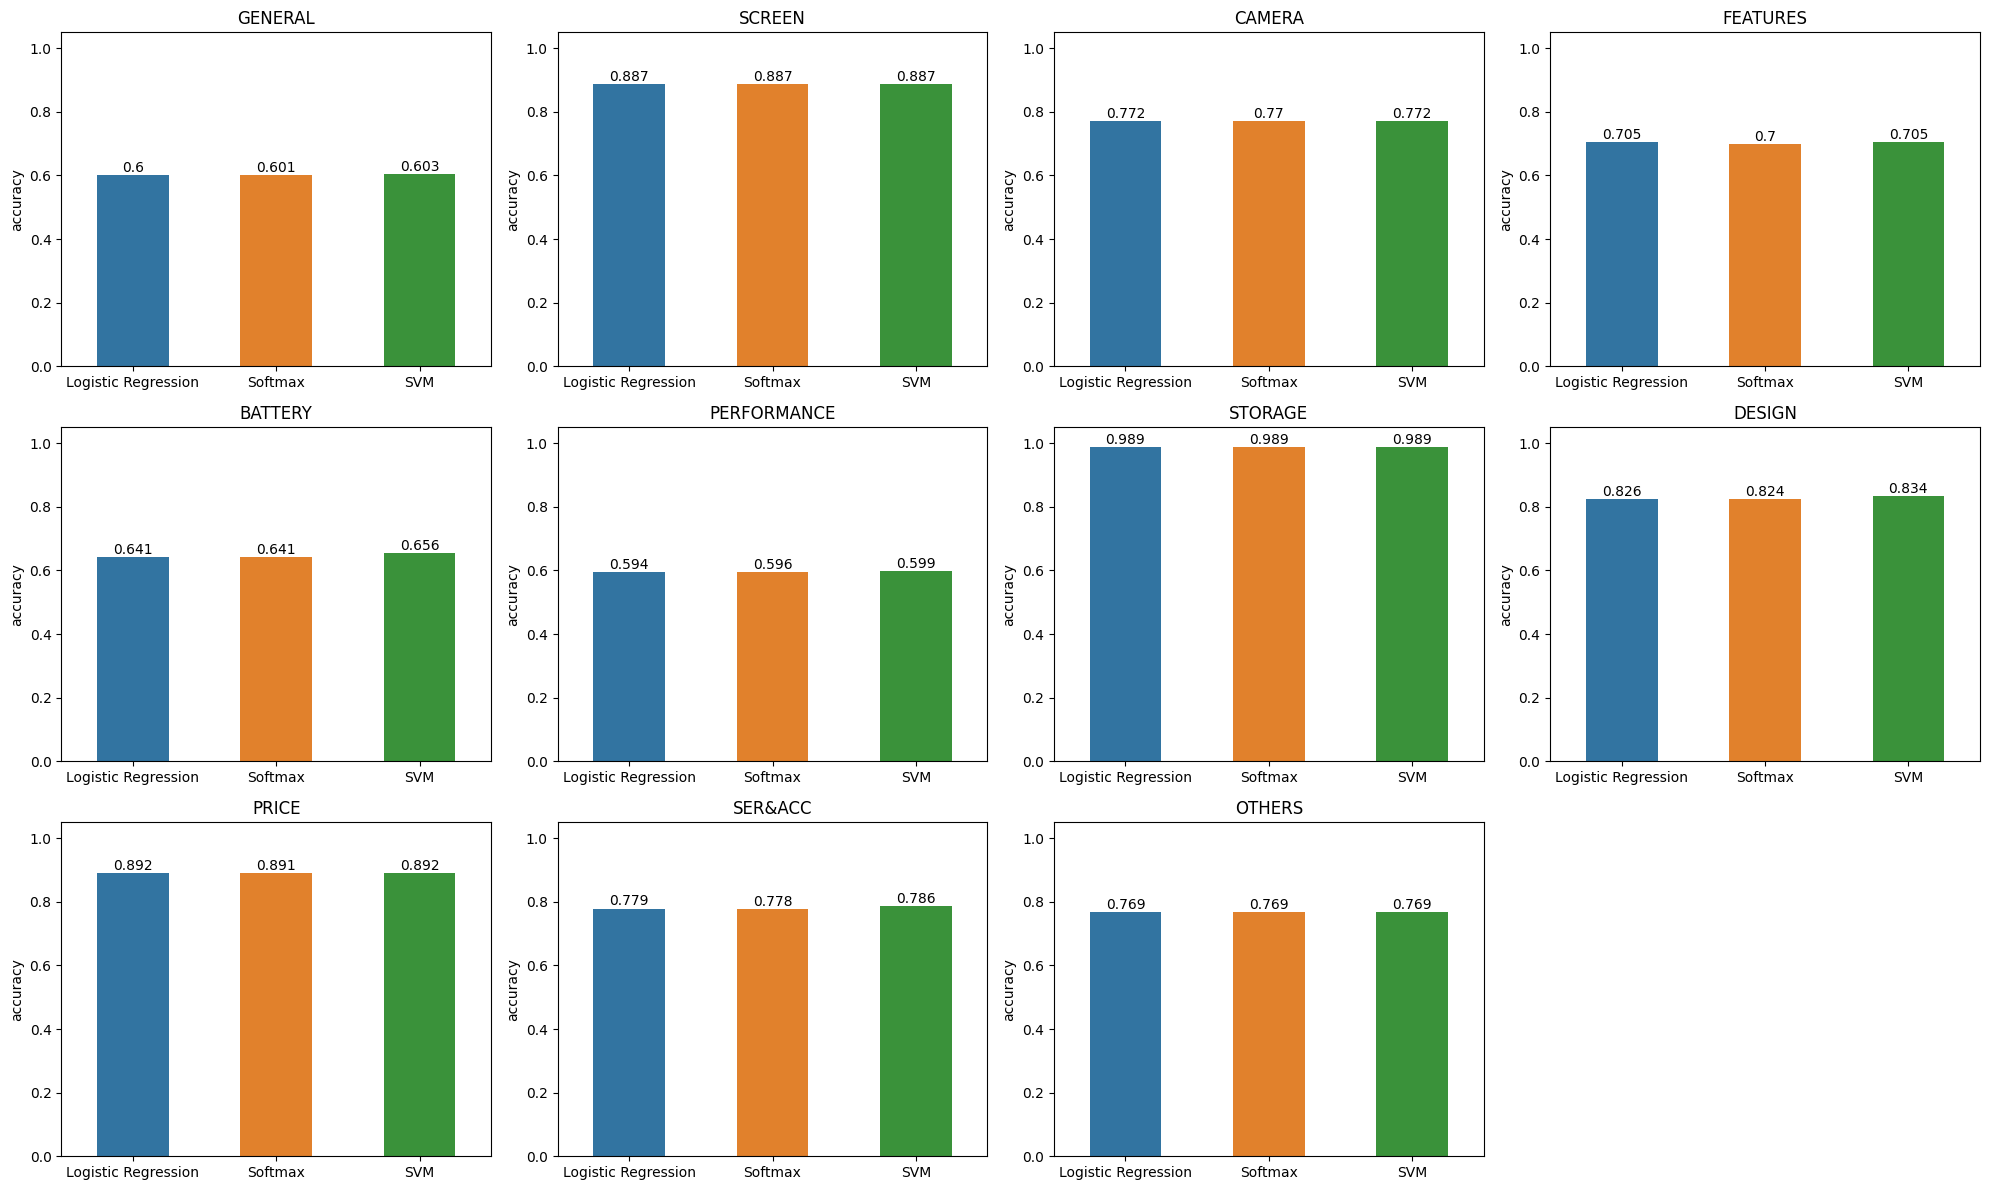

In [72]:
compare_models(df_evaluation_pca)